In [177]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Objective: Predict Electricity Consumption using Time Series

Read data

In [254]:
df = pd.read_excel('D202.xlsx')

In [255]:
df = df.drop(['TYPE', 'START TIME', 'END TIME', 'UNITS', 'NOTES', 'COST'], axis=1)

Set_index is to make the default x axis as a time scale. 

In [256]:
df = df.set_index(df['DATE'], drop=True)

In [257]:
df = df.fillna(method='ffill')

In [258]:
df = df.drop(['DATE'], axis = 1)

Organize consumption by day. 

In [259]:
df = df.resample('D').sum()

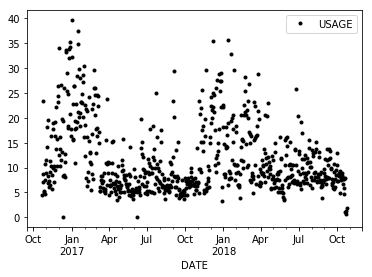

In [260]:
df.plot(style='k.')
plt.show()

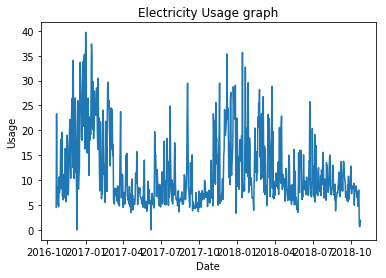

In [261]:
plt.xlabel("Date")
plt.ylabel("Usage")
plt.title("Electricity Usage graph")
plt.plot(df)

Create a plot of observed, trend, seasonality, and residuals. 

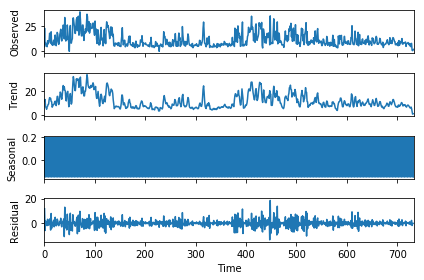

In [262]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["USAGE"].values, freq=3)
result.plot()
plt.show()

Find the rolling means and rolling standard deviation. Test to see if the data meets the stationarity test. That is, check if the p-value is below 0.05. 

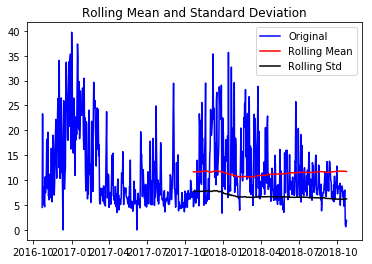

Results of dickey fuller test
Test Statistics                 -2.423278
p-value                          0.135274
No. of lags used                19.000000
Number of observations used    713.000000
critical value (5%)             -2.865602
critical value (1%)             -3.439555
critical value (10%)            -2.568933
dtype: float64


In [263]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(365).mean()
    rolstd = timeseries.rolling(365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['USAGE'],autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

We see the p-value is greater than 0.05 so the data is not stationary. Also the test statistics are greater than the critical values. 

We take the log of the series to reduce the magnitude of the values and reduce the rising trend in the series

Then after doing that, we find the rolling average of the series. 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


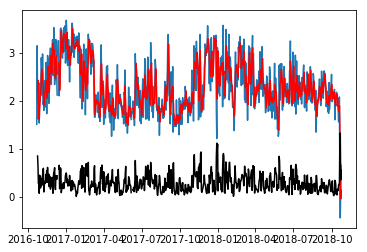

In [265]:
df_log = np.log(df)
moving_avg = df_log.rolling(3).mean()
std_dev = df_log.rolling(3).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and mean at every point in the series. Why? To eliminate trends and obtain a more stationary series. 

In [266]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Now test for stationarity using the Dickey-Fuller test. 

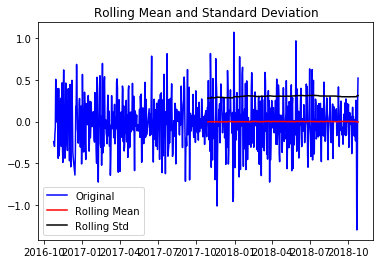

Results of dickey fuller test
Test Statistics               -8.816614e+00
p-value                        1.926649e-14
No. of lags used               2.000000e+01
Number of observations used    7.040000e+02
critical value (5%)           -2.865654e+00
critical value (1%)           -3.439673e+00
critical value (10%)          -2.568961e+00
dtype: float64


In [267]:
test_stationarity(df_log_moving_avg_diff)

The data is stationary as seen by the very low p-value. 

Now fin the differce between the log of the values and the moving average. 

In [268]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

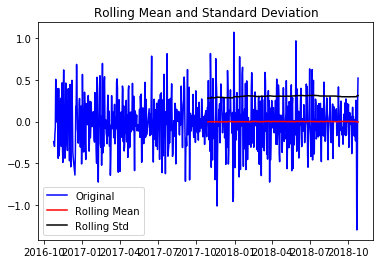

Results of dickey fuller test
Test Statistics               -8.816614e+00
p-value                        1.926649e-14
No. of lags used               2.000000e+01
Number of observations used    7.040000e+02
critical value (5%)           -2.865654e+00
critical value (1%)           -3.439673e+00
critical value (10%)          -2.568961e+00
dtype: float64


In [269]:
test_stationarity(df_log_moving_avg_diff)


Now we want to find the differences between the log of the value and the weighted averages. 

In [270]:
weighted_average = df_log.ewm(halflife=3, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
df_log_moving_avg_diff.dropna(inplace=True)

Let's test for stationarity again. 

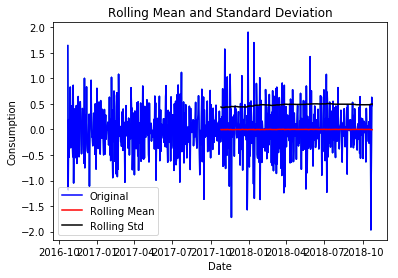

Results of dickey fuller test
Test Statistics               -9.130509e+00
p-value                        3.031054e-15
No. of lags used               1.800000e+01
Number of observations used    7.090000e+02
critical value (5%)           -2.865625e+00
critical value (1%)           -3.439607e+00
critical value (10%)          -2.568945e+00
dtype: float64


In [272]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

#Let us test the stationarity of our resultant series
df_log_diff = df_log_diff.replace([np.inf, -np.inf], np.nan)
df_log_diff.dropna(inplace=True)

test_stationarity(df_log_diff)

Eliminate nan values and infiniti values. 

In [273]:
df_log = df_log.replace([np.inf, -np.inf], np.nan)
df_log.dropna(inplace=True)

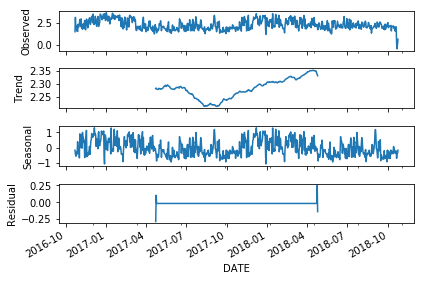

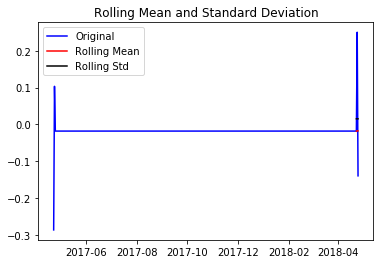

Results of dickey fuller test
Test Statistics                -39.312383
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    366.000000
critical value (5%)             -2.869469
critical value (1%)             -3.448344
critical value (10%)            -2.570994
dtype: float64


In [274]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 365)
result.plot()
plt.show()

trend = result.trend
trend.dropna(inplace=True)

seasonality = result.seasonal
seasonality.dropna(inplace=True)

residual = result.resid
residual.dropna(inplace=True)

test_stationarity(residual)

Now we need to find the optimal parameters for our ARIMA model. To find this, we will use ACF and PACF plots. 

ARIMA(p,d,q)

p → Number of autoregressive terms,
d → Number of nonseasonal differences needed for stationarity, and
q → Number of lagged forecast errors in the prediction equation.
Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

ACF- we want to find time series observations with points and compare them to values at the same series at previous times

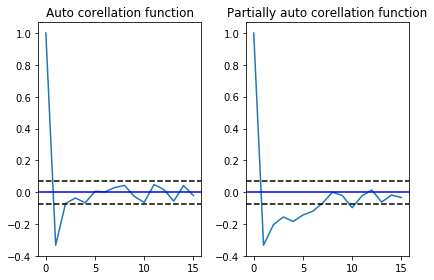

In [275]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

We need to find the cases where the graph drops to zero for the first time. 

In [276]:
se = (result_AR.fittedvalues-df_log_diff["USAGE"])**2

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


11.070296085591618

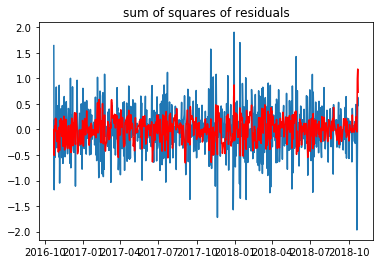

In [277]:
from statsmodels.tsa.arima_model import ARIMA
import math
model = ARIMA(df_log, order=(1,1,1))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
math.sqrt(((result_AR.fittedvalues-df_log_diff["USAGE"])**2).sum())

Predict future values. 

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


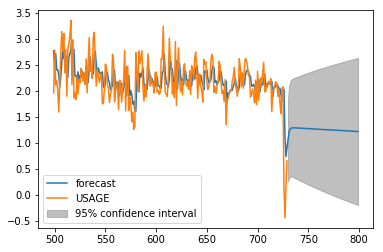

In [278]:
import datetime
#Start = datetime(2016,10,22)
#End = datetime(2019,1,1)
result_AR.plot_predict(500,800)
graph = result_AR.forecast(steps=200)


Find the confidence interval of the predicted values. 

In [280]:
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    forecast, stderr, conf = result_AR.forecast(alpha=a)
    print('%.1f%% Prediction Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))


80.0% Prediction Interval: 1.057 between 0.533 and 1.581
90.0% Prediction Interval: 1.057 between 0.385 and 1.730
95.0% Prediction Interval: 1.057 between 0.256 and 1.859
99.0% Prediction Interval: 1.057 between 0.004 and 2.111
